In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Initializing Hyperparameters
batch_size = 2**10
learning_rate = 0.001 
num_epochs = 50
num_classes = 100
num_workers = 16
train_ratio = 0.8

In [3]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),   
    transforms.ToTensor(),           
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])

train_dataset = datasets.ImageFolder(root='../data/cassia', transform=transform)
# Filter the dataset to include only the first n classes
filtered_indices = []
for i in tqdm(range(len(train_dataset)), total = (len(train_dataset) / 10572)* num_classes):
    if train_dataset[i][1] >= num_classes:
        break
    filtered_indices.append(i)
filtered_train_dataset = torch.utils.data.Subset(train_dataset, filtered_indices)

 87%|████████▋ | 4022/4640.77752553916 [00:01<00:00, 2732.08it/s]


In [4]:
train_size = int(train_ratio * len(filtered_train_dataset))
test_size = len(filtered_train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(filtered_train_dataset, [train_size, test_size])

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(f'Training dataset size: {train_size}')
print(f'Testing dataset size: {test_size}')

Training dataset size: 3217
Testing dataset size: 805


In [5]:
def F_computeAccuracy(preds, y):
	"""Compute the accuracy

	Parameters
	----------
	preds: (m, 1)
	predicted value by the MLP
	y: (m, 1)
	ground-truth class to predict
	"""

	m = y.shape[0]
	if preds.shape[1] == 1:
		hard_preds = (preds > 0.5).to(torch.int64)
	else:
		hard_preds = (torch.argmax(preds, 1)).to(torch.int64)
	return torch.sum(hard_preds==y) / m

In [6]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),   
    transforms.ToTensor(),           
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])


resnet18 = models.resnet18( num_classes=num_classes);
optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and loss function to the GPU
resnet18 = resnet18.to(device)
loss_fn = loss_fn.to(device)

train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

cnt = 0 
for num_epoch in range(1, num_epochs + 1):
    resnet18.train()
    for batch_idx, batch in enumerate(train_loader):
        # --- Forward
        X, y = batch
        X, y = X.to(device), y.to(device)  # Move tensors to the GPU

        train_preds = resnet18(X)
        loss = loss_fn(train_preds, y)

        # --- Store results on train
        train_loss.append(loss.item())

        # --- Backward
        optimizer.zero_grad()
        loss.backward()

        # --- Update parameters
        optimizer.step()
        accuracy = F_computeAccuracy(train_preds, y)

        cnt += 1
        print(cnt)
        if cnt%5 == 0:
            with torch.no_grad():
                resnet18.eval()
                for batch_idx, batch in enumerate(test_loader):
                    X_test, y_test = batch
                    X_test, y_test = X_test.to(device), y_test.to(device)  # Move tensors to the GPU
                    test_preds = resnet18(X_test)
                    loss_test = loss_fn(test_preds, y_test)
                    accuracy_test = F_computeAccuracy(test_preds, y_test)
                    print(f'TEST Loss : {loss_test.item()}, epoch : {num_epoch}, accuracy : {accuracy_test}')
                    del X_test, y_test, test_preds, loss_test, accuracy_test
        
        print(f'Loss : {loss.item()}, epoch : {num_epoch}, accuracy : {accuracy}')

1
Loss : 4.752089500427246, epoch : 1, accuracy : 0.005859375
2
Loss : 4.4481730461120605, epoch : 1, accuracy : 0.07421875
3
Loss : 4.072787284851074, epoch : 1, accuracy : 0.17578125
4
Loss : 4.16844367980957, epoch : 1, accuracy : 0.14482758939266205
5
TEST Loss : 4.243344783782959, epoch : 2, accuracy : 0.09192546457052231
Loss : 3.9212286472320557, epoch : 2, accuracy : 0.154296875
6
Loss : 4.184257984161377, epoch : 2, accuracy : 0.1044921875
7
Loss : 4.520603179931641, epoch : 2, accuracy : 0.0517578125
8
Loss : 5.3835906982421875, epoch : 2, accuracy : 0.062068965286016464
9
Loss : 4.010249137878418, epoch : 3, accuracy : 0.1474609375
10
TEST Loss : 4.521359920501709, epoch : 3, accuracy : 0.03105589933693409
Loss : 3.9260342121124268, epoch : 3, accuracy : 0.1533203125
11
Loss : 4.528079509735107, epoch : 3, accuracy : 0.02734375
12
Loss : 4.465604305267334, epoch : 3, accuracy : 0.04137931019067764
13
Loss : 3.810713768005371, epoch : 4, accuracy : 0.1982421875
14
Loss : 3.66

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.6784314].


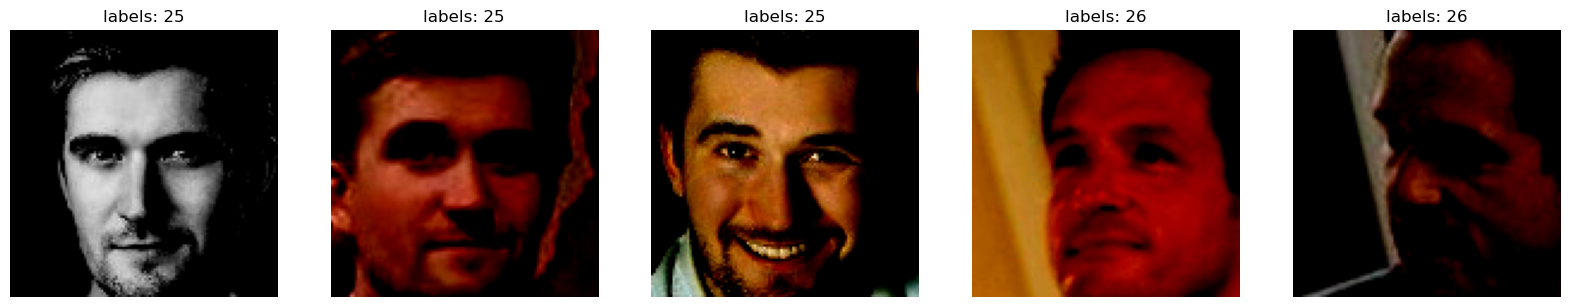

In [15]:
# show some images in train_dataset
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    img, label = train_dataset[i+1000]
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'labels: {label}')
    ax.axis('off')
plt.show()